In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score, make_scorer
import matplotlib.pyplot as plt

# Number of infected dataset

In [2]:
cc_data = pd.read_csv('cleaned_confirmed_cases.csv')
cc_data = pd.concat([cc_data,pd.get_dummies(cc_data['Country_Region'], prefix='country')],axis=1)
diff_split_cc_data = cc_data.copy()
# dropping first infection along with country and date
cc_data.drop(['Country_Region', 'Date', 'first_infection'],axis=1, inplace=True)
feature_cols = list(cc_data)
feature_cols.remove('TargetValue')
mask_test = (diff_split_cc_data['Date'] >= '2020-05-20')
mask_train = (diff_split_cc_data['Date'] < '2020-05-20')

In [3]:
test_cc_df = diff_split_cc_data.loc[mask_test]
train_cc_df = diff_split_cc_data.loc[mask_train]
y_time_split_cc = train_cc_df['TargetValue']
x_time_split_cc = train_cc_df[feature_cols] 

y_test_time_split_cc = test_cc_df['TargetValue']
x_test_time_split_cc = test_cc_df[feature_cols]

In [4]:
gradient_boosting_regr = GradientBoostingRegressor()
gradient_boosting_regr.fit(x_time_split_cc,y_time_split_cc)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [5]:
y_pred_cc = gradient_boosting_regr.predict(x_test_time_split_cc)
print(gradient_boosting_regr.score(x_test_time_split_cc, y_test_time_split_cc))

0.797985163700536


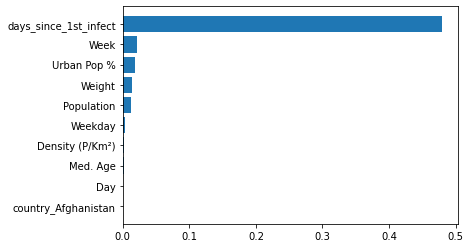

In [21]:
feature_imp = gradient_boosting_regr.feature_importances_[:10]
sorted_idx = np.argsort(feature_imp)
pos = np.arange(sorted_idx.shape[0])+.5

plt.barh(pos, feature_imp[sorted_idx], align='center')
plt.yticks(pos, np.array(list(x_time_split_cc))[sorted_idx])
plt.show()

## Optimizing hyperparams

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
params = { 'learning_rate': list(np.logspace(np.log10(0.08), np.log10(0.2), base = 10, num = 600)),
             'max_depth': list(range(2, 5)),
             'min_samples_leaf':list(range(1,3)),
            'n_estimators':list(range(1,40))}

In [58]:
params_opt = { 'learning_rate': list(np.logspace(np.log10(0.08), np.log10(0.2), base = 10, num = 600)),
             'max_depth': [3, 4, 5],
             'min_samples_leaf':list(range(1,4))}

In [59]:
rand_search = RandomizedSearchCV(gradient_boosting_regr, params_opt, scoring= 'r2', n_iter = 100)
search = rand_search.fit(x_time_split_cc,y_time_split_cc)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [73]:
best_params= search.best_params_
optGBR = GradientBoostingRegressor(learning_rate= best_params['learning_rate'], min_samples_leaf=best_params['min_samples_leaf'],
                      max_depth=best_params['max_depth'])
optGBR.fit(x_time_split_cc,y_time_split_cc)
y_pred_cc = optGBR.predict(x_test_time_split_cc)
print(optGBR.score(x_test_time_split_cc, y_test_time_split_cc))

0.8435165698845433


In [62]:
best_params #0.8424614151546296

{'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.16980307604394845}

In [53]:
best_params #0.8167473387570496

{'n_estimators': 26,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'learning_rate': 0.08110900098081626}

In [47]:
best_params #0.8468788650739416

{'n_estimators': 21,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'learning_rate': 0.11355963299468902}

In [33]:
best_params #0.8321867359659648

{'n_estimators': 22,
 'min_samples_leaf': 2,
 'max_depth': 4,
 'learning_rate': 0.08859518365155593}

In [42]:
best_params #0.8433987577464361

{'n_estimators': 15,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'learning_rate': 0.1459405019886716}

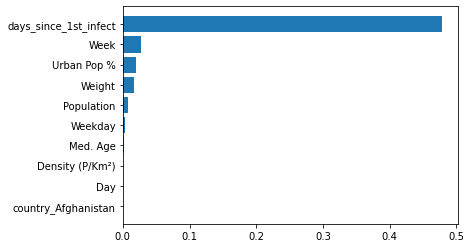

In [75]:
feature_imp = optGBR.feature_importances_[:10]
sorted_idx = np.argsort(feature_imp)
pos = np.arange(sorted_idx.shape[0])+.5

plt.barh(pos, feature_imp[sorted_idx], align='center')
plt.yticks(pos, np.array(list(x_time_split_cc))[sorted_idx])
plt.show()

# Fatalities dataset

In [63]:
f_data = pd.read_csv('cleaned_fatalities.csv')
mask_f_test = (f_data['Date'] >= '2020-05-20')
mask_f_train = (f_data['Date'] < '2020-05-20')
test_f_df = diff_split_cc_data.loc[mask_f_test]
train_f_df = diff_split_cc_data.loc[mask_f_train]
y_time_split_f = train_f_df['TargetValue']
x_time_split_f = train_f_df[feature_cols] 
y_test_time_split_f = test_f_df['TargetValue']
x_test_time_split_f = test_f_df[feature_cols]

In [64]:
gradient_boosting_regr_f = GradientBoostingRegressor()
gradient_boosting_regr_f.fit(x_time_split_f,y_time_split_f)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
y_pred_cc = gradient_boosting_regr.predict(x_test_time_split_f)
print(gradient_boosting_regr.score(x_test_time_split_f, y_test_time_split_f))

0.797985163700536


In [66]:
params_opt = { 'learning_rate': list(np.logspace(np.log10(0.08), np.log10(0.2), base = 10, num = 600)),
             'max_depth': [3, 4, 5],
             'min_samples_leaf':list(range(1,4))}

In [68]:
rand_search_f = RandomizedSearchCV(gradient_boosting_regr, params_opt, scoring= 'r2', n_iter = 100)
search_f = rand_search_f.fit(x_time_split_f,y_time_split_f)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [70]:
best_params= search.best_params_
optGBR = GradientBoostingRegressor(learning_rate= best_params['learning_rate'], min_samples_leaf=best_params['min_samples_leaf'],
                      max_depth=best_params['max_depth'])
optGBR.fit(x_time_split_f,y_time_split_f)
y_pred_cc = optGBR.predict(x_test_time_split_f)
print(optGBR.score(x_test_time_split_f, y_test_time_split_f))

0.8429173721385695


In [71]:
best_params

{'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.16980307604394845}

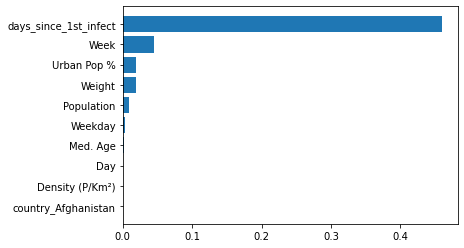

In [72]:
feature_imp = optGBR.feature_importances_[:10]
sorted_idx = np.argsort(feature_imp)
pos = np.arange(sorted_idx.shape[0])+.5

plt.barh(pos, feature_imp[sorted_idx], align='center')
plt.yticks(pos, np.array(list(x_time_split_f))[sorted_idx])
plt.show()